In [1]:
import pandas as pd
import os
from pandas import read_csv
from pandas import read_parquet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pyarrow
import fastparquet
from datetime import datetime, timezone, timedelta
import scipy.stats as s

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/data/INRIX'
os.chdir(work_dir)

selected_state = 'CA'
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
meter_to_mile = 0.000621371
vehicle_lookup = {2: 'MDT', 3:'HDT'}
tp_lookup = {0: 'Evening',
             1: 'Evening',
             2: 'Evening',
             3: 'Evening',
             4: 'Evening',
             5: 'Evening',
             6: 'AM peak',
             7: 'AM peak',
             8: 'AM peak',
             9: 'AM peak',
             10: 'Midday',
             11: 'Midday',
             12: 'Midday',
             13: 'Midday',
             14: 'Midday',
             15: 'Midday',
             16: 'PM peak',
             17: 'PM peak',
             18: 'PM peak',
             19: 'PM peak',
             20: 'Evening',
             21: 'Evening',
             22: 'Evening',
             23: 'Evening'}

In [2]:
# data process function
def inrix_data_cleaning(data):
    
    # data filtering & cleaning
    data = data.loc[data['mode'] == 1] # vehicle
    data = data.loc[data['movement_type'] == 1] # moving trips
    data = data.loc[data['vehicle_weight_class'].isin([2,3])] # MDV + HDV
    data = data.loc[data['provider_type'] == 2] # fleet vehicles
    data = data.dropna(subset = ['start_cbg', 'end_cbg']) 
    
    # generate time-related attributes
    tz = data.start_tz.unique()[0]
#     print(tz)
    data.loc[:, 'start_date'] = data.loc[:, 'start_date'].str.split('.').str[0]
    data.loc[:, 'end_date'] = data.loc[:, 'end_date'].str.split('.').str[0]

    data['start_time'] = \
    pd.to_datetime(data['start_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
    data['start_time'] = data['start_time'].dt.tz_localize('utc').dt.tz_convert(tz)

    data['end_time'] = \
    pd.to_datetime(data['end_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
    data['end_time'] = data['end_time'].dt.tz_localize('utc').dt.tz_convert(tz)
    data.loc[:, 'start_hour'] = \
    data.loc[:, 'start_time'].dt.hour
    data.loc[:, 'end_hour'] = \
    data.loc[:, 'end_time'].dt.hour
    data.loc[:, 'dayofweek'] = \
    data.loc[:, 'start_time'].dt.dayofweek
    data.loc[:, 'travel_time'] = data.loc[:, 'end_time'] - data.loc[:, 'start_time'] 
    data.loc[:, 'date'] = data.loc[:, 'start_time'].dt.date
    # generate travel impedance
    data.loc[:, 'travel_time_h'] =  data.loc[:, 'travel_time']/ pd.Timedelta(hours=1)
    data.loc[:, 'trip_distance_mile'] = data.loc[:, 'trip_distance_m'] * meter_to_mile
    
    # generate O-D info
    data.loc[:, ['start_cbg', 'end_cbg']] = data.loc[:, ['start_cbg', 'end_cbg']].astype(int)
#     data.loc[:, 'o_GEOID'] = data.loc[:, 'start_cbg'] / 10
#     data.loc[:, 'd_GEOID'] = data.loc[:, 'end_cbg'] / 10
#     data.loc[:, ['o_GEOID', 'd_GEOID']] = data.loc[:, ['o_GEOID', 'd_GEOID']].astype(int)
    return(data)

In [3]:
# bildaq_od_data = read_csv('Output/' + selected_state+ '/OD_summary_with_routed_distance.csv')
list_of_inrix_folder = os.listdir(selected_state + '_trips')
inrix_trip_out = None
daily_trip_count_out = None
out_attr = ['trip_id', 'o_GEOID', 'd_GEOID', 'travel_time_h', 'trip_distance_mile']
agg_var = ['start_cbg', 'end_cbg', 'start_hour', 'vehicle_weight_class']
for folder in list_of_inrix_folder:
    if folder == '.DS_Store':
        continue
    print(folder)
    list_of_inrix_trips = os.listdir(selected_state + '_trips/' + folder)
    trip_dir = selected_state + '_trips/' + folder
    for file in list_of_inrix_trips:
        if file.endswith('.parquet'):
#             print(file)
            inrix_trips = read_parquet(trip_dir + '/' + file, engine = 'auto')
#             sample_raw_data = inrix_trips.head(1000)
#             sample_raw_data.to_csv('sampletrips/sample_raw_INRIX_data.csv', index = False)
            inrix_trips = inrix_data_cleaning(inrix_trips)
            daily_trip_count = inrix_trips.groupby(['vehicle_weight_class', 'date', 'dayofweek']).size()
            daily_trip_count = daily_trip_count.reset_index()
            inrix_trips = inrix_trips.loc[inrix_trips['dayofweek']<= 4] # select only weekday data
# #             sample_cleaned_data = inrix_data_cleaning(sample_raw_data)
# #             sample_cleaned_data.to_csv('sampletrips/sample_cleaned_INRIX_data.csv', index = False)
# #             inrix_trips = inrix_trips[out_attr]
            
#             # generate skims
            od_skim = inrix_trips.groupby(agg_var).agg({'travel_time_h':'sum', 
                                                                       'trip_distance_mile':'sum',
                                                                       'trip_id':'count'})
            od_skim = od_skim.reset_index()
            od_skim.columns = ['start_cbg', 'end_cbg', 'start_hour', 'vehicle_weight_class', 
                               'travel_time_h', 'trip_distance_mile', 'trip_count']
            inrix_trip_out = pd.concat([inrix_trip_out, od_skim])
            daily_trip_count_out = pd.concat([daily_trip_count_out, daily_trip_count])
#         break
#     break
print(len(inrix_trip_out))
daily_trip_count_out.head(5)
# inrix_trips.head(5)

inrix.trips.20200121.ca
inrix.trips.20200115.ca
inrix.trips.20200124.ca
inrix.trips.20200120.ca
inrix.trips.20200114.ca
inrix.trips.20200119.ca
inrix.trips.20200118.ca
inrix.trips.20200113.ca
inrix.trips.20200123.ca
inrix.trips.20200117.ca
inrix.trips.20200122.ca
inrix.trips.20200116.ca
3338063


,vehicle_weight_class,date,dayofweek,0
0,2,2020-01-20,0,4602
1,2,2020-01-21,1,29290
2,3,2020-01-20,0,1682
3,3,2020-01-21,1,6696
0,2,2020-01-20,0,4492


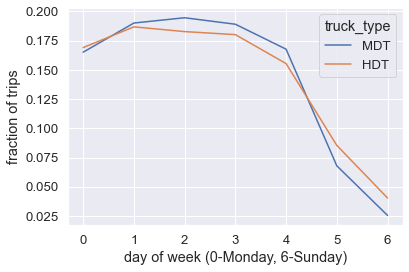

In [4]:
# day of week distribution
daily_trip_count_out.columns = ['vehicle_weight_class',	'date',	'dayofweek', 'trip_count']
daily_trip_count_agg = \
daily_trip_count_out.groupby(['vehicle_weight_class', 'date', 'dayofweek'])[['trip_count']].sum()
daily_trip_count_agg = daily_trip_count_agg.reset_index()
# daily_trip_count_agg.head(5)
avg_trips_per_day = daily_trip_count_agg.groupby(['vehicle_weight_class', 'dayofweek'])[['trip_count']].mean()
avg_trips_per_day = avg_trips_per_day.reset_index()
avg_trips_per_day.loc[:, 'fraction'] = \
avg_trips_per_day.loc[:, 'trip_count'] /\
avg_trips_per_day.groupby(['vehicle_weight_class'])['trip_count'].transform('sum')
avg_trips_per_day.loc[:, 'truck_type'] = \
avg_trips_per_day.loc[:, 'vehicle_weight_class'].map(vehicle_lookup)
sns.lineplot( data = avg_trips_per_day, 
             x = "dayofweek", y = "fraction", 
            hue = "truck_type")
plt.xlabel('day of week (0-Monday, 6-Sunday)')
plt.ylabel('fraction of trips')
plt.savefig('Plot/' + selected_state + '/time_of_week_distribution.png', 
            dpi = 200, bbox_inches = 'tight')
avg_trips_per_day.to_csv('Skim_freight/' + selected_state + '_time_of_week_distribution.csv', index = False)

In [5]:
# generate travel time and distance skim

# inrix_trip_out.loc[:, 'travel_time_h'].head(5)
travel_time_by_od = inrix_trip_out.groupby(agg_var)[['trip_distance_mile', 
                                                     'travel_time_h', 'trip_count']].sum()
travel_time_by_od = travel_time_by_od.reset_index()
# travel_time_by_od.loc[:, 'trip_distance_m'] *= meter_to_mile

# travel_time_by_od.columns = ['o_GEOID', 'd_GEOID', 'distance_mile', 'travel_time_h', 'trip_count']
print(len(travel_time_by_od))
print(travel_time_by_od.trip_count.sum())
travel_time_by_od.head(5)
# travel_time_by_od.to_csv('Skim/CA_travel_time.csv')

2226391
3485145


,start_cbg,end_cbg,start_hour,vehicle_weight_class,trip_distance_mile,travel_time_h,trip_count
0,60014001001,60014001001,7,2,0.110511,0.025000,1
1,60014001001,60014001001,8,2,0.433312,0.046111,1
2,60014001001,60014001001,9,2,10.396865,0.741389,3
3,60014001001,60014001001,10,2,2.351097,0.325000,6
4,60014001001,60014001001,11,2,7.458365,1.532500,7


In [6]:

travel_time_by_od.loc[:, 'trip_avg_speed_mph'] = travel_time_by_od.loc[:, 'trip_distance_mile'] / travel_time_by_od.loc[:, 'travel_time_h']
travel_time_by_od.loc[:, 'trip_distance_mile'] = travel_time_by_od.loc[:, 'trip_distance_mile'] / travel_time_by_od.loc[:, 'trip_count']
travel_time_by_od.loc[:, 'travel_time_h'] = travel_time_by_od.loc[:, 'travel_time_h'] / travel_time_by_od.loc[:, 'trip_count']


travel_time_by_od.to_csv('Skim_freight/' + selected_state + '_travel_time.csv', index = False)

In [8]:
# truck trip temporal distribution

truck_trip_count_by_hour = \
travel_time_by_od.groupby(['start_hour', 'vehicle_weight_class'])[['trip_count']].sum()
truck_trip_count_by_hour = truck_trip_count_by_hour.reset_index()
truck_trip_count_by_hour.loc[:, 'truck_type'] = \
truck_trip_count_by_hour.loc[:, 'vehicle_weight_class'].map(vehicle_lookup)


truck_trip_count_by_hour.loc[:, 'fraction'] = \
truck_trip_count_by_hour.loc[:, 'trip_count'] / \
truck_trip_count_by_hour.groupby(['truck_type'])['trip_count'].transform('sum')

truck_trip_count_by_hour.head(5)
truck_trip_count_by_hour.to_csv('Skim_freight/' + selected_state + '_hour_factor.csv')                            
# sns.lineplot( data = truck_trip_count_by_hour, 
#              x = "start_hour", y = "trip_count", 
#             hue = "truck_type")
# plt.xlabel('depature hour')
# plt.ylabel('INRIX trips')
# plt.savefig('Plot/' + selected_state + '/truck_trip_tod_distribution.png',
#            dpi = 200, bbox_inches = 'tight')

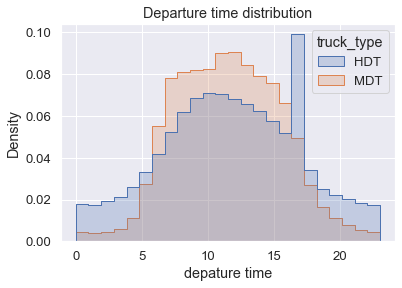

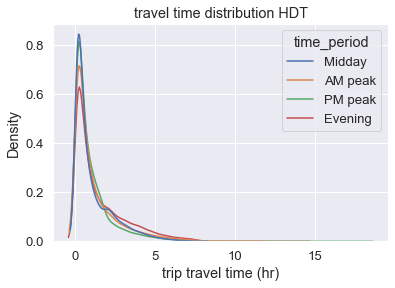

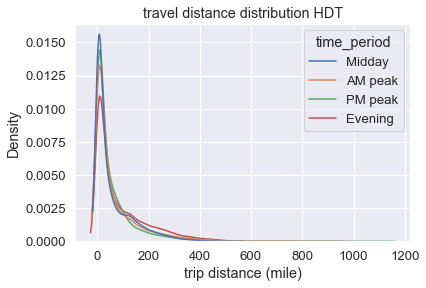

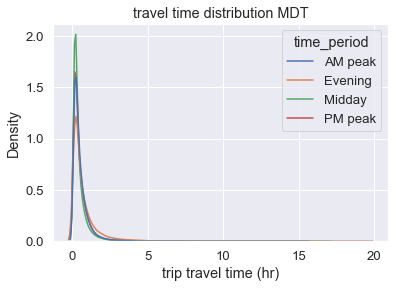

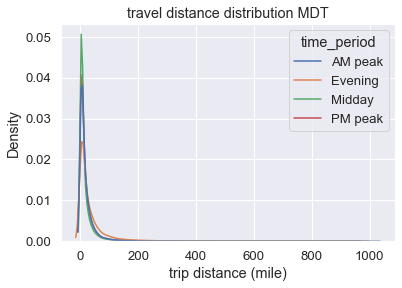

In [7]:
# plot travel time distribution
travel_time_by_od.loc[:, 'truck_type'] = \
travel_time_by_od.loc[:, 'vehicle_weight_class'].map(vehicle_lookup)
travel_time_by_od.loc[:, 'time_period'] = \
travel_time_by_od.loc[:, 'start_hour'].map(tp_lookup)
veh_types = travel_time_by_od['truck_type'].unique()
travel_time_by_od['start_hour'] = travel_time_by_od['start_hour'].astype(int)
sns.histplot(data = travel_time_by_od, 
             x = 'start_hour', 
             hue= 'truck_type', 
             weights='trip_count', stat = 'density', element="step",
             bins=24, kde=False, common_norm=False)
plt.title('Departure time distribution')
plt.xlabel('depature time')
plt.savefig('Plot/' + selected_state + '/truck_departure_distribution.png',
       dpi = 200, bbox_inches = 'tight')
plt.show()


for vt in veh_types:
    travel_time_to_plot = \
    travel_time_by_od.loc[travel_time_by_od['truck_type'] == vt]
     
    sns.kdeplot(data=travel_time_to_plot, 
                 x = 'travel_time_h', 
                 hue= 'time_period', 
                 weights='trip_count', common_norm = False)
    plt.title('travel time distribution ' + vt)
    plt.xlabel('trip travel time (hr)')
    plt.savefig('Plot/' + selected_state + '/truck_trip_tt_distribution_' + vt + '.png',
           dpi = 200, bbox_inches = 'tight')
    plt.show()
    
    sns.kdeplot(data=travel_time_to_plot, 
                 x = 'trip_distance_mile', 
                 hue= 'time_period', 
                 weights='trip_count', common_norm = False)
    plt.title('travel distance distribution ' + vt)
    plt.xlabel('trip distance (mile)')
    plt.savefig('Plot/' + selected_state + '/truck_trip_dist_distribution_' + vt + '.png',
           dpi = 200, bbox_inches = 'tight')
    plt.show()